In [1]:
!pip install -q paho-mqtt matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 5.8 MB/s eta 0:00:00


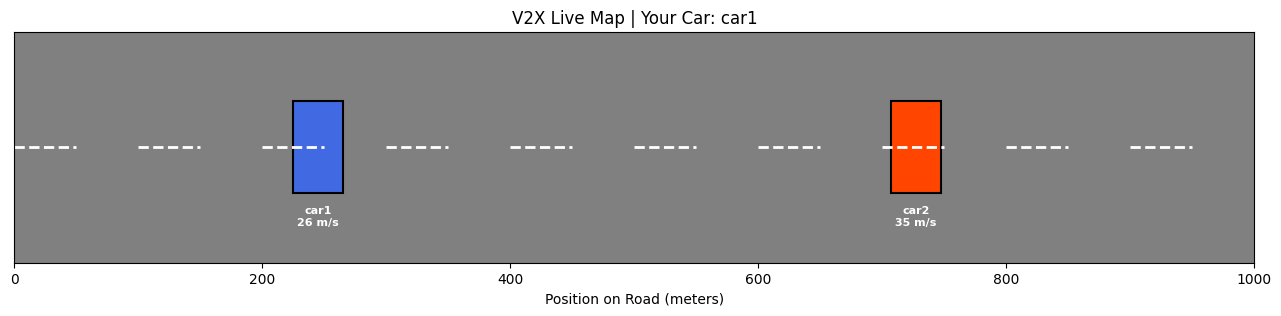

In [ ]:
# ==========================
# 1. INSTALL LIBRARIES
# ==========================
!pip install -q paho-mqtt matplotlib

# ==========================
# 2. IMPORT LIBRARIES
# ==========================
import paho.mqtt.client as mqtt
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output

# ==========================
# 3. CONFIGURATION
# ==========================
BROKER = "broker.emqx.io"
PORT = 1883
# Using a more specific topic to avoid interference with other users' projects
TOPIC = "v2x/vehicles/simulation_map"
SAFE_DISTANCE = 30      # The distance (in meters) for triggering a warning
LANE_LENGTH = 1000      # The total length of our simulated road (in meters)

# Get user input for this vehicle's ID
VEHICLE_ID = input("Enter Vehicle ID (e.g., CAR1, CAR2, CAR3): ")

# Data structure to hold the state of ALL vehicles seen on the network
all_vehicles = {}

# This specific vehicle's state
vehicle_state = {
    "id": VEHICLE_ID,
    "position": random.randint(0, 100),
    "speed": random.randint(15, 35) # Speed in meters per second for simulation
}

# ==========================
# 4. VISUALIZATION FUNCTION
# ==========================
def update_map(vehicles):
    """
    Clears the Colab output and redraws the road with all vehicles.
    """
    # This is the key command for live updates in Colab
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(16, 3))

    # --- Set up the road appearance ---
    ax.set_facecolor('gray')
    ax.set_xlim(0, LANE_LENGTH)
    ax.set_ylim(0, 2)
    ax.set_yticks([]) # We don't need a y-axis
    ax.set_xlabel("Position on Road (meters)")
    ax.set_title(f"V2X Live Map | Your Car: {VEHICLE_ID}")

    # Draw lane markings
    for i in range(0, LANE_LENGTH, 100):
        ax.plot([i, i + 50], [1, 1], color='white', linestyle='--', linewidth=2)

    # --- Car dimensions for drawing ---
    car_width = 40  # meters
    car_height = 0.8

    # --- Draw each vehicle from our shared state dictionary ---
    for vehicle_id, data in vehicles.items():
        pos = data.get("position", 0)
        # Your car is blue, others are red
        color = 'royalblue' if vehicle_id == VEHICLE_ID else 'orangered'

        # Create a rectangle patch for the car
        car_rect = patches.Rectangle(
            (pos - car_width / 2, 1 - car_height / 2),
            car_width,
            car_height,
            linewidth=1.5,
            edgecolor='black',
            facecolor=color
        )
        ax.add_patch(car_rect)

        # Add a text label with the car's ID and speed
        speed = data.get("speed", 0)
        ax.text(pos, 0.4, f"{vehicle_id}\n{speed} m/s", color='white', ha='center', va='center', fontsize=8, fontweight='bold')

    plt.show()

# ==========================
# 5. MQTT CALLBACKS
# ==========================
def on_connect(client, userdata, flags, rc):
    """Callback for when the client connects to the MQTT broker."""
    if rc == 0:
        print(f"[{VEHICLE_ID}] Connected to MQTT Broker!")
        client.subscribe(TOPIC)
    else:
        print(f"[{VEHICLE_ID}] Failed to connect, return code {rc}")

def on_message(client, userdata, msg):
    """Callback for when a message is received."""
    global all_vehicles
    try:
        # Decode the message payload: "CAR_ID,position,speed"
        message = msg.payload.decode()
        sender_id, pos_str, speed_str = message.split(",")
        pos = int(pos_str)
        speed = int(speed_str)

        # Update the state of the sender vehicle in our global dictionary
        all_vehicles[sender_id] = {
            "position": pos,
            "speed": speed,
            "last_updated": time.time()
        }

        # --- Collision Warning Logic (kept from original code) ---
        if sender_id != VEHICLE_ID:
            my_pos = vehicle_state["position"]
            distance = abs(my_pos - pos)

            # A more realistic check: warning if the other car is ahead and too close
            if my_pos < pos and distance < SAFE_DISTANCE:
                 print(
                     f"⚠️ WARNING: {VEHICLE_ID} too close to {sender_id} ahead! "
                     f"(distance {distance:.1f} m)"
                 )

    except Exception as e:
        print(f"Error parsing message: {e}")

# ==========================
# 6. MQTT CLIENT SETUP
# ==========================
# Make client ID unique to avoid conflicts when running multiple instances
client = mqtt.Client(client_id=f"{VEHICLE_ID}-{random.randint(100, 999)}", protocol=mqtt.MQTTv311)
client.on_connect = on_connect
client.on_message = on_message

try:
    client.connect(BROKER, PORT, keepalive=60)
except Exception as e:
    print(f"Could not connect to MQTT Broker: {e}")

client.loop_start()

# ==========================
# 7. SIMULATION LOOP
# ==========================
try:
    print("Starting simulation... Run this code in other Colab notebooks to see more cars!")
    time.sleep(2) # Give a moment for the client to connect

    while True:
        # --- 1. Update this vehicle's state ---
        # Move the car forward. The modulo (%) makes the car reappear at the start
        # when it reaches the end, creating a continuous loop on the road.
        vehicle_state["position"] = (vehicle_state["position"] + vehicle_state["speed"]) % LANE_LENGTH

        # Update our own car's data in the shared dictionary for visualization
        all_vehicles[VEHICLE_ID] = {
            "position": vehicle_state["position"],
            "speed": vehicle_state["speed"],
            "last_updated": time.time()
        }

        # --- 2. Remove old/stale vehicle data ---
        current_time = time.time()
        stale_vehicles = [
            vid for vid, data in all_vehicles.items()
            if current_time - data.get("last_updated", 0) > 10 # 10-second timeout
        ]
        for vid in stale_vehicles:
            # Safely remove the stale vehicle
            all_vehicles.pop(vid, None)
            print(f"[{VEHICLE_ID}] Removed stale vehicle data for: {vid}")

        # --- 3. Broadcast this vehicle's new state ---
        message = f"{VEHICLE_ID},{vehicle_state['position']},{vehicle_state['speed']}"
        client.publish(TOPIC, message)

        # --- 4. Update the visual map ---
        update_map(all_vehicles)

        # --- 5. Wait for the next cycle ---
        time.sleep(1) # Update rate of 1 frame per second

except KeyboardInterrupt:
    print(f"\n[{VEHICLE_ID}] Simulation stopped by user.")
finally:
    client.loop_stop()
    client.disconnect()
    print(f"[{VEHICLE_ID}] Disconnected from MQTT Broker.")